In [1]:
from __future__ import print_function
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision import models, transforms
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from functools import partial

from few_shot_learning.datasets import FashionProductImages, FashionProductImagesSmall
from few_shot_learning.utils_evaluation import ToSize
from few_shot_learning.transfer import main, validate
from few_shot_learning.utils import restore_model, allocate_inputs, allocate_model, accuracy
from config import DATA_PATH

# 1. Data Preprocessing and Statistics

In [138]:
# all_data = FashionProductImages(DATA_PATH, split='all', classes=None)

In [ ]:
datasets = dict()

for classes in ['top', 'bottom']:
    
    datasets[classes] = dict()
    
    for split in ['train', 'test']:
        
        dataset = FashionProductImages(DATA_PATH, split=split, classes=classes, transform=ToSize())
        size = len(dataset)
        loader = DataLoader(dataset, batch_size=size, shuffle=False, num_workers=8)
        
        # use loader to efficiently load all images using multiple workers
        for widths_heights, labels in loader:
            break
        
        widths, heights = widths_heights
        widths = widths.numpy()
        heights = heights.numpy()
        labels = labels.numpy()
        
        datasets[classes][split] = dict(data=dataset,
                                        size=size,
                                        loader=loader,
                                        widths=widths,
                                        heights=heights,
                                        labels=labels)

# print(datasets)

### Distribution of image sizes and aspect ratios

[ 200  480  720 1440 1600 1800 2000 2400 2700 3000 3888 5616]
[ 150  360  540 1080 1200 1350 1500 1799 1800 2250 2592 2700 3744]


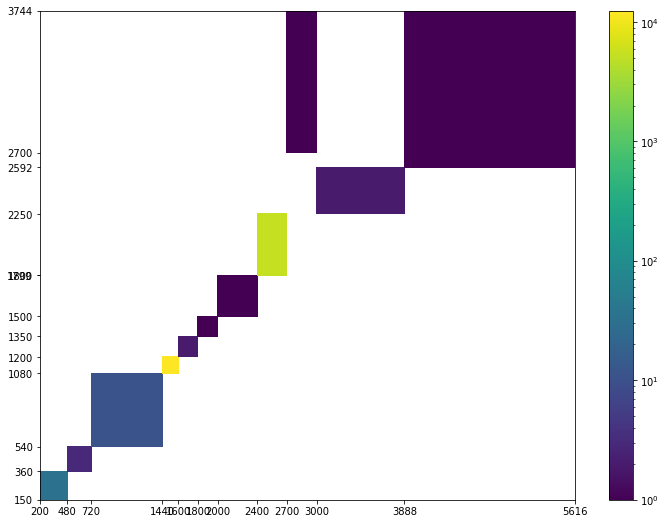

In [67]:
from matplotlib.colors import LogNorm

unique_heights = np.unique(datasets['top']['train']['heights'])
unique_widths = np.unique(datasets['top']['train']['widths'])
print(unique_heights)
print(unique_widths)

plt.figure(figsize=(12,9))
plt.hist2d(
    datasets['top']['train']['heights'],
    datasets['top']['train']['widths'],
    bins=[unique_heights, unique_widths],
    norm=LogNorm(),
)
plt.xticks(unique_heights)
plt.yticks(unique_widths)
plt.colorbar()
plt.show()

[1.         1.33333333 1.33407449 1.5       ]
17996


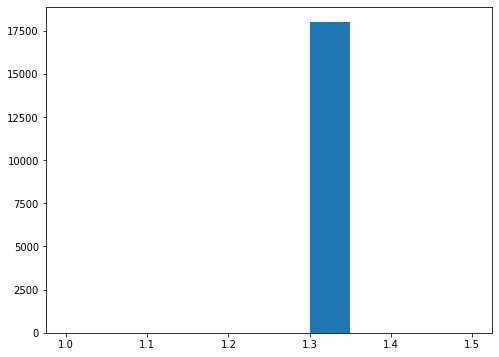

In [49]:
aspect_ratios = datasets['top']['train']['heights']/datasets['top']['train']['widths']
unique_aspect_ratios = np.unique(aspect_ratios)
print(unique_aspect_ratios)
print((aspect_ratios == 4/3).sum())

plt.figure(figsize=(8,6))
plt.hist(aspect_ratios)
plt.show()

## Distribution of labels

In [35]:
def get_mapped_class_dist(dataset, classes, normed=False):
    class_dist = np.bincount(dataset.target_indices, minlength=len(classes))
    
    if normed:
        class_dist = class_dist / class_dist.sum()
        
    class_indices = dataset.target_codec.transform(classes)
    
    return class_dist[class_indices]
    

In [36]:
# top 20 classes
top20 = FashionProductImages.top20_classes

plt.figure(figsize=(12,9))
plt.bar(top20, get_mapped_class_dist(datasets['top']['train']['data'], top20), label='training set', width=0.4, align='edge')
plt.bar(top20, get_mapped_class_dist(datasets['top']['test']['data'], top20), label='test set', width=-0.4, align='edge')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

#plt.figure(figsize=(12,9))
#plt.bar(top20, get_mapped_class_dist(datasets['top']['train']['data'], top20, normed=True), label='training set', width=0.4, align='edge')
#plt.bar(top20, get_mapped_class_dist(datasets['top']['test']['data'], top20, normed=True), label='test set', width=-0.4, align='edge')
#plt.xticks(rotation='vertical')
#plt.legend()
#plt.show()

NameError: name 'datasets' is not defined

<Figure size 864x648 with 0 Axes>

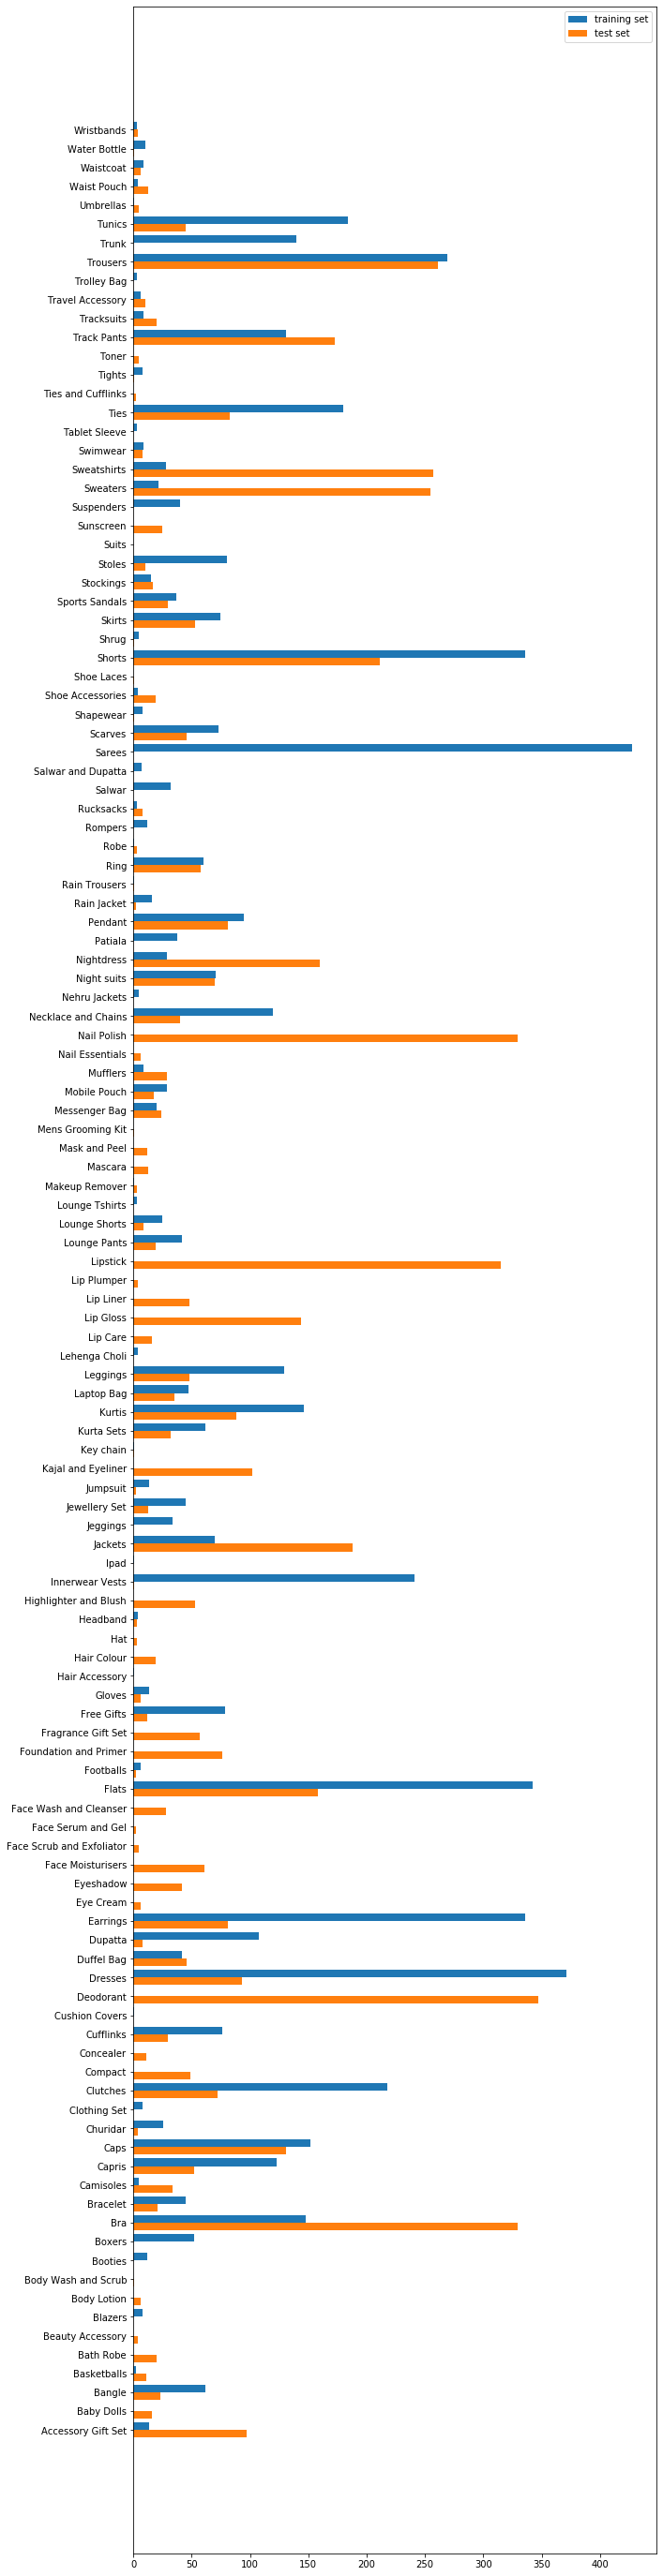

In [108]:
bottom123 = datasets['bottom']['train']['data'].target_codec.classes_

bottom_train_dist = get_mapped_class_dist(datasets['bottom']['train']['data'], bottom123)
bottom_test_dist =get_mapped_class_dist(datasets['bottom']['test']['data'], bottom123)

plt.figure(figsize=(10,50))
plt.barh(bottom123, bottom_train_dist, label='training set', height=0.4, align='edge')
plt.barh(bottom123, bottom_test_dist, label='test set', height=-0.4, align='edge')
# plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [110]:
# classes not present in the training set while present in the test set
print(bottom123[(bottom_test_dist > 0) & (bottom_train_dist == 0)])

# amount of test samples affected
print(bottom_test_dist[(bottom_test_dist > 0) & (bottom_train_dist == 0)].sum())
print(bottom_test_dist.sum())

# classes not present in the test set while present in the training set
print(bottom123[(bottom_test_dist == 0) & (bottom_train_dist > 0)])

# amount of samples in training set that don't do anything
print(bottom_train_dist[(bottom_test_dist == 0) & (bottom_train_dist > 0)].sum())


# classes neither in the training set nor test set
print(bottom123[(bottom_test_dist == 0) & (bottom_train_dist == 0)])

['Baby Dolls' 'Bath Robe' 'Beauty Accessory' 'Body Lotion'
 'Body Wash and Scrub' 'Compact' 'Concealer' 'Deodorant' 'Eye Cream'
 'Eyeshadow' 'Face Moisturisers' 'Face Scrub and Exfoliator'
 'Face Serum and Gel' 'Face Wash and Cleanser' 'Foundation and Primer'
 'Fragrance Gift Set' 'Hair Colour' 'Hat' 'Highlighter and Blush'
 'Kajal and Eyeliner' 'Lip Care' 'Lip Gloss' 'Lip Liner' 'Lip Plumper'
 'Lipstick' 'Mascara' 'Mask and Peel' 'Mens Grooming Kit'
 'Nail Essentials' 'Nail Polish' 'Shoe Laces' 'Sunscreen'
 'Ties and Cufflinks' 'Toner']
1829
5505
['Blazers' 'Booties' 'Boxers' 'Clothing Set' 'Cushion Covers'
 'Hair Accessory' 'Ipad' 'Jeggings' 'Lehenga Choli' 'Lounge Tshirts'
 'Nehru Jackets' 'Patiala' 'Rompers' 'Salwar' 'Salwar and Dupatta'
 'Sarees' 'Suspenders' 'Tablet Sleeve' 'Trolley Bag' 'Trunk']
831
['Suits']


# 2. Training

In [ ]:
main(
    datadir=DATA_PATH,
    architecture='resnet50',
    num_workers=8,
    epochs=100,
    batch_size=64,
    learning_rate=1e-3,
    optimizer=torch.optim.Adam,
    print_freq=50,
    resume=False,
    evaluate=False,
    seed=None,
    device=None,
    distributed=True,
    date=False,
    model_dir="./models",
    log_dir="./models"
)

# 3. Evaluation

### Monitoring Training

In [2]:
LOG_DIR = os.path.expanduser("/home/ubuntu/few-shot-learning/logs/")
MODEL_DIR = os.path.expanduser("/home/ubuntu/few-shot-learning/models/")

folder = "19_10_08_1917"

In [3]:
finetuning_results = torch.load(os.path.join(LOG_DIR, folder, "finetuning_training_log.json"))
transfer_results = torch.load(os.path.join(LOG_DIR, folder, "transfer_training_log.json"))

In [4]:
finetuning_best_model = torch.load(os.path.join(MODEL_DIR, folder, "finetuning_model_best.pth.tar"))
transfer_best_model = torch.load(os.path.join(MODEL_DIR, folder, "transfer_model_best.pth.tar"))

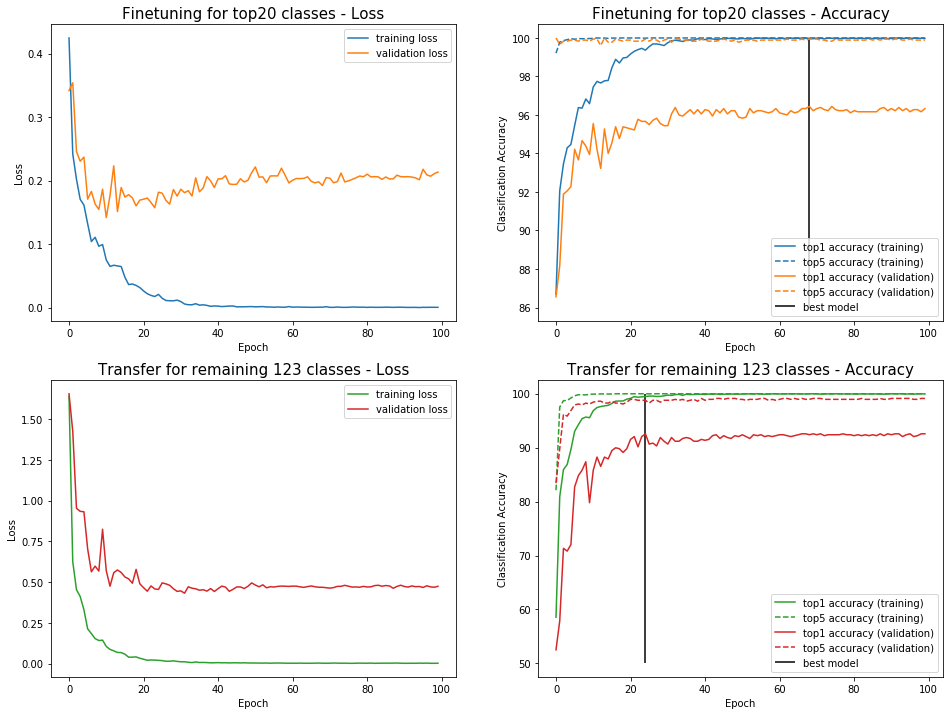

In [5]:
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors

plt.figure(figsize=(16,12))

plt.subplot(221)
plt.plot(finetuning_results["train_loss"], label="training loss")
plt.plot(finetuning_results["val_loss"], label="validation loss")
plt.title("Finetuning for top20 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(222)
plt.plot(finetuning_results["train_acc1"], label="top1 accuracy (training)", color='#1f77b4')
plt.plot(finetuning_results["train_acc5"], label="top5 accuracy (training)", color='#1f77b4', linestyle="--")
plt.plot(finetuning_results["val_acc1"], label="top1 accuracy (validation)", color='#ff7f0e')
plt.plot(finetuning_results["val_acc5"], label="top5 accuracy (validation)", color='#ff7f0e', linestyle="--")
plt.vlines(finetuning_best_model["epoch"]-1, 86, 100, label="best model")
plt.title("Finetuning for top20 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.subplot(223)
plt.plot(transfer_results["train_loss"], label="training loss", color='#2ca02c')
plt.plot(transfer_results["val_loss"], label="validation loss", color='#d62728')
plt.title("Transfer for remaining 123 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(224)
plt.plot(transfer_results["train_acc1"], label="top1 accuracy (training)", color='#2ca02c')
plt.plot(transfer_results["train_acc5"], label="top5 accuracy (training)", color='#2ca02c', linestyle="--")
plt.plot(transfer_results["val_acc1"], label="top1 accuracy (validation)", color='#d62728')
plt.plot(transfer_results["val_acc5"], label="top5 accuracy (validation)", color='#d62728', linestyle="--")
plt.vlines(transfer_best_model["epoch"]-1, 50, 100, label="best model")
plt.title("Transfer for remaining 123 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.show()

### Performance on Test Set

In [10]:
transform = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

testset = FashionProductImages(DATA_PATH, classes="top", split="test", transform=transform)

test_loader = DataLoader(testset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=8)

In [11]:
model = models.resnet50()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, testset.n_classes)
model = allocate_model(None, True, None, "resnet50", model)
model.load_state_dict(finetuning_best_model["state_dict"])

allocate_inputs_ = partial(allocate_inputs, None, True, None)

In [ ]:
model.eval()

outputs = []
targets = []

with torch.no_grad():
    # end = time.time()
    for i, (images, target) in enumerate(test_loader):
        images, target = allocate_inputs_(images, target)

        # compute output
        output = model(images)
        # loss = criterion(output, target)
        
        outputs.append(output)
        targets.append(target)

outputs = torch.cat(outputs)
targets = torch.cat(targets)

In [59]:
acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
acc1_avg = acc1.item()
acc5_avg = acc5.item()

print(acc1_avg, acc5_avg)

88.32266235351562 95.35282897949219


In [48]:
acc1_classwise = np.zeros(testset.n_classes) # [0.0 for _ in range(testset.n_classes)]
acc5_classwise = np.zeros(testset.n_classes) # [0.0 for _ in range(testset.n_classes)]

for c in range(testset.n_classes):
    is_class = (targets == c)
    acc1, acc5 = accuracy(outputs[is_class, :], targets[is_class], topk=(1, 5))
    acc1_classwise[c] = acc1.item()
    acc5_classwise[c] = acc5.item()


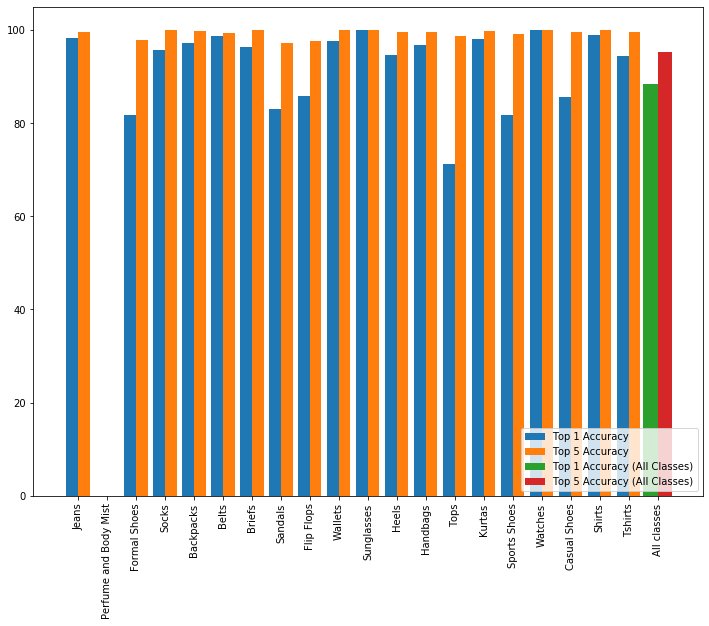

In [58]:
plt.figure(figsize=(12,9))
plt.bar(top20 + ["All classes"], list(acc1_classwise[testset.target_codec.transform(top20)]) + [0.0], label='Top 1 Accuracy', width=-0.4, align='edge')
plt.bar(top20 + ["All classes"], list(acc5_classwise[testset.target_codec.transform(top20)]) + [0.0], label='Top 5 Accuracy', width=0.4, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', width=-0.5, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', width=0.5, align='edge')
plt.xticks(rotation='vertical')
plt.legend(loc="lower right")
plt.show()

In [60]:
testset = FashionProductImages(DATA_PATH, classes="bottom", split="test", transform=transform)

test_loader = DataLoader(testset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=8)

model = models.resnet50()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, testset.n_classes)
model = allocate_model(None, True, None, "resnet50", model)
model.load_state_dict(transfer_best_model["state_dict"])

allocate_inputs_ = partial(allocate_inputs, None, True, None)

In [61]:
model.eval()

outputs = []
targets = []

with torch.no_grad():
    # end = time.time()
    for i, (images, target) in enumerate(test_loader):
        images, target = allocate_inputs_(images, target)

        # compute output
        output = model(images)
        # loss = criterion(output, target)
        
        outputs.append(output)
        targets.append(target)

outputs = torch.cat(outputs)
targets = torch.cat(targets)

In [62]:
acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
acc1_avg = acc1.item()
acc5_avg = acc5.item()

print(acc1_avg, acc5_avg)

46.7938232421875 60.526790618896484


In [67]:
acc1_classwise = np.zeros(testset.n_classes)
acc5_classwise = np.zeros(testset.n_classes)

for c in range(testset.n_classes):
    is_class = (targets == c)
    if is_class.any():
        acc1, acc5 = accuracy(outputs[is_class, :], targets[is_class], topk=(1, 5))
        acc1_classwise[c] = acc1.item()
        acc5_classwise[c] = acc5.item()
    else:
        acc1_classwise[c] = -1.0
        acc5_classwise[c] = -1.0

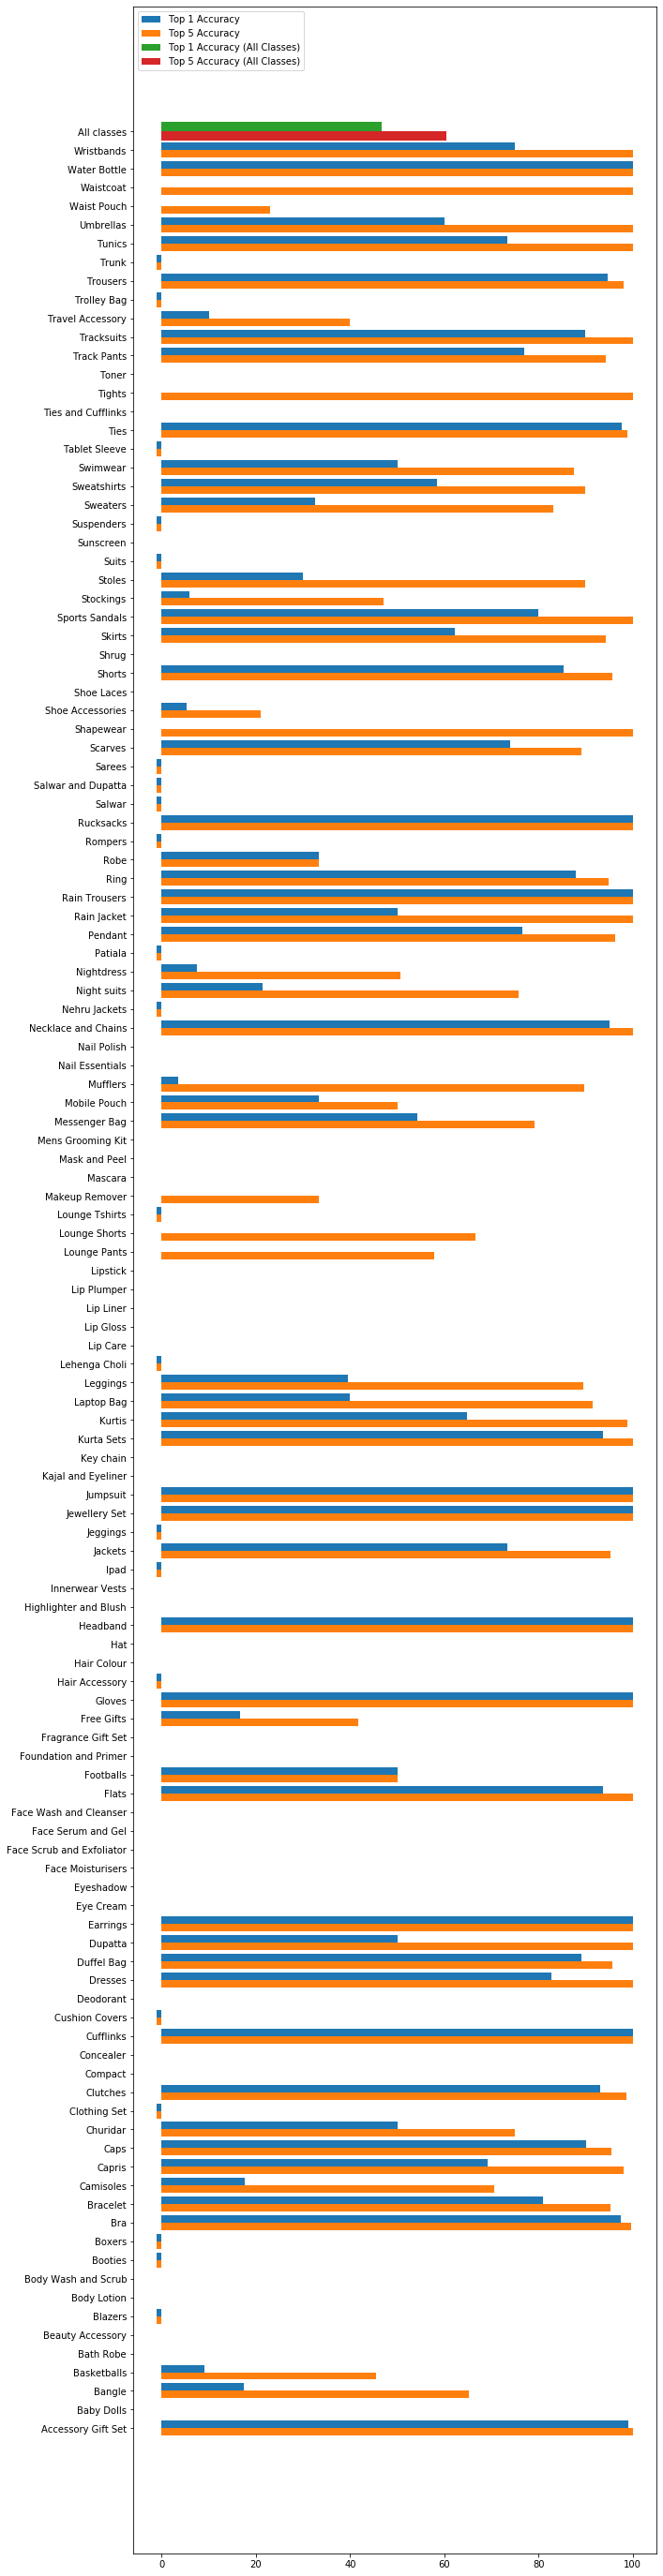

In [76]:
bottom123 = list(testset.target_codec.classes_)

plt.figure(figsize=(10,50))
plt.barh(bottom123 + ["All classes"], list(acc1_classwise[testset.target_codec.transform(bottom123)]) + [0.0], label='Top 1 Accuracy', height=0.4, align='edge')
plt.barh(bottom123 + ["All classes"], list(acc5_classwise[testset.target_codec.transform(bottom123)]) + [0.0], label='Top 5 Accuracy', height=-0.4, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', height=0.5, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', height=-0.5, align='edge')
plt.legend(loc="upper left")
plt.show()